### DCGANs - FashionMNIST dataset.

* In this notebook we are going to create a network that will generate fake fashion mnist images using DCGAN's.

### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets

tf.__version__

'2.5.0'

### Data preparation.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

### Creating a helper function that plots images.

In [3]:
def plot_images(images:[], rows=5, columns=5):
  assert len(images) == rows * columns
  plt.figure(figsize=(15, 15))
  for i in range(rows * columns):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap = plt.cm.binary)
  plt.show()

### Ploting Images.

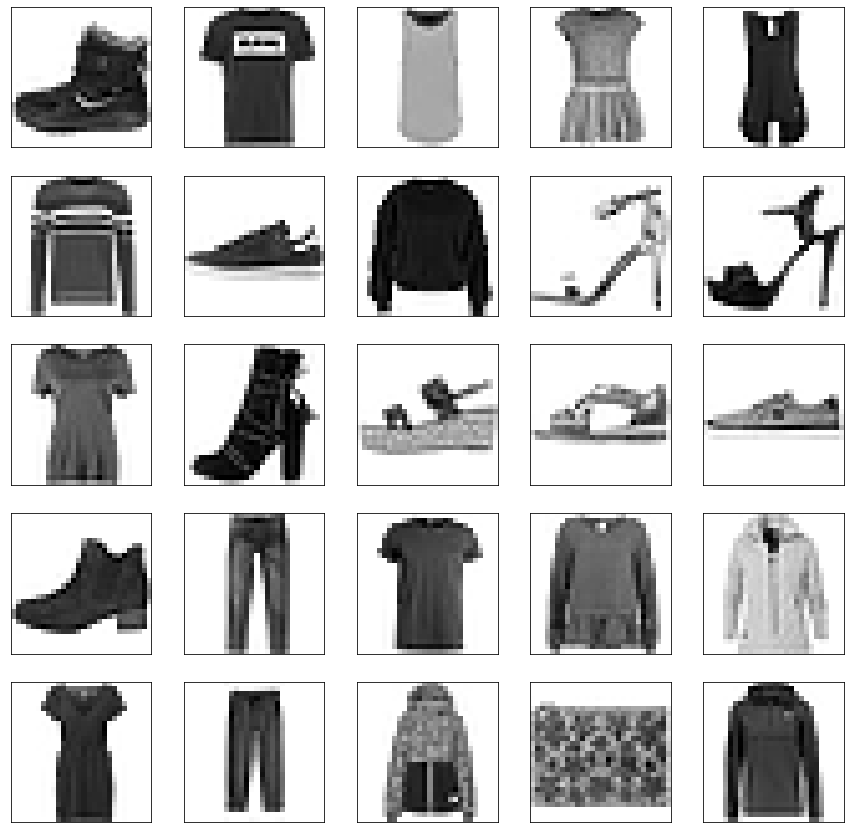

In [4]:
plot_images(train_images[:25])

### Creating dataset.

In [5]:
normalize= lambda x: x/255
shapping = lambda x: tf.reshape(x, (28, 28, 1))

In [6]:
BATCH_SIZE = 64

ds = tf.data.Dataset.from_tensor_slices(train_images).map(shapping).map(normalize).batch(BATCH_SIZE,
                                                                      drop_remainder = True
                                                                      ).shuffle(train_images.shape[0]
                                                                                ).prefetch(1)

### The `G` Model using functional API

In [7]:
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Input(shape=(num_features, )),
    keras.layers.Dense(7 * 7 * 128),
    keras.layers.Reshape((7, 7, 128)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding ="same", activation ="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
], name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
_________________________________________________

### Discriminator Model.

In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1 )),
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same",),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
], name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

###  Overiding the `train_step`




In [9]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim

  # .compile()
  def compile(self, d_optimizer, g_optimizer, criterion):
    super(GAN, self).compile()
    self.criterion = criterion
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metric(self):
    return [
       self.d_loss_metric,
       self.g_loss_metric     
    ]

  # .fit()
  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    """
    Train the discriminator
    """
    with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.criterion(labels, predictions)
    """
    Calculate the gradients of the discriminator
    """        
    gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(gradients, self.discriminator.trainable_weights )
    )
    """
    Regenerate the latent_vectors for the generators and create misleading 
    labels and train the generator.
    """
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))
    with tf.GradientTape() as tape:
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.criterion(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    """
    RETURM METRICS AS A DICTIONARY.
    """
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }

### Callbacks.

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=2, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

early = keras.callbacks.EarlyStopping(monitor= "g_loss", 
                      mode= "auto", 
                      patience = 5)

### Trainning the NN.

In [11]:
epochs = 100
latent_dim = 100
gan = GAN(discriminator, 
          generator, 
          latent_dim
          )
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    criterion=keras.losses.BinaryCrossentropy(from_logits=False),
)
gan.fit(
    ds, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim), early]
)

Epoch 1/100
937/937 [==============================] - 32s 29ms/step - d_loss: 0.6082 - g_loss: 1.0166
Epoch 2/100
937/937 [==============================] - 29s 29ms/step - d_loss: 0.5829 - g_loss: 1.0205
Epoch 3/100
937/937 [==============================] - 29s 29ms/step - d_loss: 0.4708 - g_loss: 1.2499
Epoch 4/100
937/937 [==============================] - 29s 29ms/step - d_loss: 0.4074 - g_loss: 1.4457
Epoch 5/100
937/937 [==============================] - 29s 29ms/step - d_loss: 0.4306 - g_loss: 1.4912
Epoch 6/100
937/937 [==============================] - 30s 29ms/step - d_loss: 0.4461 - g_loss: 1.4509


### Generating images.

In [12]:
generated_images_from_model = gan.generator(tf.random.normal(shape=(15, 100)))

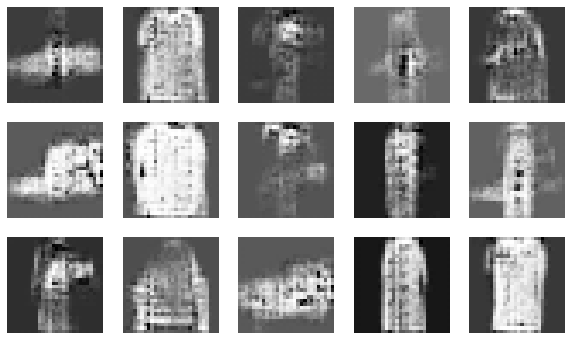

In [13]:
def plot_images(images, cols=5):
  rows = 3
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, image in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image[:, :, 0], cmap="gray")
plot_images(generated_images_from_model)
plt.show()